In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
from typing import Dict, List, Tuple
from buffer_pool_baseline.timer import Time
from buffer_pool_baseline.cache import Cache
from buffer_pool_baseline.strategy import EvictionStrategy
from buffer_pool_baseline.environment import Query

In [4]:
%matplotlib inline

In [5]:
def setup():
    
    t = Time(0)
    
    c = Cache(cache_size, t, equate_id_to_value=True)
    
    start = random.randint(0, 20)
    end = start + 5
    
    start_2 = start + random.randint(0, 5)
    end_2 = start_2 + 5
    
    loop_size = random.randint(1, 3)
    
    select = Query(query_type = "select", time=t, parameters={"start": start, "end": end})
    env = Query(query_type="join", time=t, parameters={"start_table_1": start, "end_table_1": end, 
                                                       "start_table_2": start_2, "end_table_2": end_2})
    env.set_query_cache(c)
    
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    c.add_element(random.randint(0, 30))
    return env

In [115]:
def multisetup():
    
    t = Time(0)
    
    c = Cache(cache_size, t, equate_id_to_value=True)
    
    start = random.randint(0, 20)
    end = start + 5
    
    join_start = random.randint(end-5, end+5)
    join_end = join_start + 5
    
    start_2 = join_start + random.randint(5, 10)
    end_2 = start_2 + 5
    
    loop_size = random.randint(1, 3)
    
    select = Query(query_type = "sequential", time=t, parameters={"start": start, "end": end, "loop_size": loop_size})
#     join_query = Query(query_type = "sequential", time=t, parameters={"start": start_2, "end": end_2, "loop_size": loop_size})
    
#     select = Query(query_type = "join", time=t, parameters={"start_table_1": join_start, "end_table_1": join_end, 
#                                                             "start_table_2": start_2, "end_table_2": end_2})
                                                                      
    join_query = Query(query_type="join", time=t, parameters={"start_table_1": join_start, "end_table_1": join_end, 
                                                       "start_table_2": start_2, "end_table_2": end_2})
    
    c.add_element(random.randint(100, 300))
    c.add_element(random.randint(100, 300))
    c.add_element(random.randint(100, 300))
    c.add_element(random.randint(100, 300))
    select.set_query_cache(c)
    join_query.set_query_cache(c)
    
    return select, join_query

In [116]:
def get_query(query_type, table_size, loop_size):
    t = Time()
    if query_type == "sequential":
        return Query(query_type="sequential", time=t, parameters={"start": 0, "end": table_size, "loop_size": loop_size})
    
    if query_type == "select":
        return Query(query_type="select", time=t, parameters={"start": 0, "end": table_size})
    
    if query_type == "join":
        return Query(query_type="join", time=t, parameters={"start_table_1": 0, "end_table_1": 10, 
                                                            "start_table_2": 0, "end_table_2": 10})
    

In [117]:
def get_time_steps_per_query(table_size, cache_size, loop_size):
    time_steps = {}
    
    query_types = ["sequential", "select", "join"]
    
    for query in query_types:
        t = Time(0)
        env = get_query(query, table_size, loop_size)
        c = Cache(cache_size, t, equate_id_to_value=True)
        env.set_query_cache(c)

        while not env.is_done():
            env.step("mru")

        time_steps[query] = env.time.now()
    
    return time_steps

In [118]:
def encode_queries(query_type, time_step, max_time_steps):
    return max_time_steps[query_type] + time_step

In [119]:
max_time_steps = get_time_steps_per_query(10, 4, 5)

In [120]:
alpha = 0.0001
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

In [121]:
q_values_cumulative = []
old_q = np.zeros([1000, 2])
q_table = np.zeros([1000, 2])
cache_size = 4

In [122]:
# q1, q2 = multisetup()

# hits, miss = 0, 0
# while not q1.is_done():
#     q1.step("lru")

# hits, miss = q1.step()

# while not q2.is_done():
#     q2.step("lru")

# h, m = q2.step()

# print(hits, miss, h, m)
    

In [73]:
cum_reward_plot = []
encoded_state = []

for i in tqdm(range(1, number_of_runs)):
    
    env = setup()
    state = encode_queries(env.query_type, env.time.now(), max_time_steps)
    
    penalties, reward, = 0, 0
    done = False
    previous_hit, previous_miss = 0, 0
    cum_reward = 0
    tm = 0
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            action = random.choice(env.actions) # Explore action space
        else:
            _action_ = np.argmax(q_table[state]) # Exploit learned values
            action = "mru" if _action_ == 0 else "lru"
            
        hits, miss = env.step(action)
        next_state = encode_queries(env.query_type, env.time.now(), max_time_steps)
        encoded_state.append(next_state)
        
        reward = hits - previous_hit
        penalties = miss - previous_miss
        
        previous_hit = hits
        previous_miss = miss
        
        done = env.done

        _action_ = 0 if action == "mru" else 1
        
        old_value = q_table[state, _action_]
        next_max = np.max(q_table[next_state])
        
        r = reward - penalties
        new_value = (1 - alpha) * old_value + alpha * (r + gamma * next_max)
        q_table[state, _action_] = new_value
        state = next_state
        cum_reward += r
        tm += 1
        
    old_q = q_table.copy()
    
    cum_reward_plot.append({"reward": cum_reward, "epoch": i, "time": tm})

print("Training finished.\n")

100%|█████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:11<00:00, 896.46it/s]

Training finished.



In [123]:
number_of_runs = 100000

In [124]:
encoded_state = []

def run_multiple():
    cum_reward_plot = []
    q_values_cumulative = []
    reward_policy = []
    
    for i in tqdm(range(1, number_of_runs)):

        q1, q2 = multisetup()
#         print(q1.query_type, q2.query_type, q1.done, q2.done)
        
        state = encode_queries(q1.query_type, q1.time.now(), max_time_steps)

        penalties, reward, = 0, 0
        done = False
        previous_hit, previous_miss = 0, 0
        cum_reward = 0
        tm = 0
        
        old_q = q_table.copy()
        
        while (not q1.is_done() or not q2.is_done()):
            if q1.is_done():
                env = q2
            else:
                env = q1
            
#             print(env.query_type)
    
            if random.uniform(0, 1) < epsilon:
                action = random.choice(env.actions) # Explore action space
            else:
                _action_ = np.argmax(q_table[state]) # Exploit learned values
                action = "mru" if _action_ == 0 else "lru"

            hits, miss = env.step(action)
#             print(env.query_type)
            next_state = encode_queries(env.query_type, env.time.now(), max_time_steps)
            encoded_state.append(next_state)
        
            reward = hits - previous_hit
            penalties = miss - previous_miss

            previous_hit = hits
            previous_miss = miss

            _action_ = 0 if action == "mru" else 1

            old_value = q_table[state, _action_]
            next_max = np.max(q_table[next_state])

            r = reward - penalties
            new_value = (1 - alpha) * old_value + alpha * (r + gamma * next_max)
            q_table[state, _action_] = new_value
            state = next_state
            cum_reward += r
            tm += 1
            
        q_values_cumulative.append({"q_values_cumulative": sum(sum(abs(old_q - q_table)))})
        
        cum_reward_plot.append({"reward": cum_reward, "epoch": i, "time": tm})
        
        if i % 100 == 0:
            total_hits = 0
            total_misses = 0

            for i in range(100):
                q1, q2 = multisetup()
                r1 = compare_query_reward(q1) 
                r2 = compare_query_reward(q2)

                total_r = {}
                for x, y in r1.items():
                    total_r[x] = y

                for x, y in r2.items():
                    total_r[x] += y
                    
                tm = q1.time.now() + q2.time.now()
                total_hits += total_r["hits_policy"] / total_r["tm"]
                total_misses += total_r["misses_policy"] / total_r["tm"]
            
            reward_policy.append({"Total Hits": total_hits, "Total Misses": total_misses})
            
    return cum_reward_plot, q_values_cumulative, reward_policy
    print("Training finished.\n")


In [125]:
cum_reward_plot, q_values_cumulative, reward = run_multiple()


  2%|█▋                                                                          | 2190/99999 [00:10<09:29, 171.82it/s]


  4%|███▎                                                                        | 4336/99999 [00:20<09:23, 169.66it/s]


  6%|████▌                                                                       | 6085/99999 [00:31<08:30, 183.79it/s]


  8%|█████▊                                                                      | 7700/99999 [00:42<10:49, 142.10it/s]


 10%|███████▏                                                                    | 9528/99999 [00:52<08:43, 172.70it/s]


 11%|████████▍                                                                  | 11320/99999 [01:02<09:26, 156.62it/s]


 13%|█████████▊                                                                 | 13051/99999 [01:13<08:56, 161.93it/s]


 15%|███████████                                                                | 14705/99999 [01:23<11:38, 122.20it/s]


 16%|████████████▎                                                              | 16406/99999 [01:34<11:16, 123.53it/s]


 18%|█████████████▌                                                             | 18156/99999 [01:44<08:15, 165.28it/s]


 20%|██████████████▉                                                            | 19845/99999 [01:54<08:02, 166.24it/s]


 22%|████████████████▏                                                          | 21642/99999 [02:05<07:28, 174.77it/s]


 23%|█████████████████▌                                                         | 23376/99999 [02:15<07:04, 180.37it/s]


 25%|██████████████████▋                                                        | 24935/99999 [02:25<07:51, 159.33it/s]


 27%|████████████████████                                                       | 26757/99999 [02:36<06:44, 181.08it/s]


 29%|█████████████████████▍                                                     | 28509/99999 [02:46<08:22, 142.30it/s]


 30%|██████████████████████▋                                                    | 30253/99999 [02:57<06:53, 168.62it/s]


 32%|████████████████████████                                                   | 32117/99999 [03:07<07:32, 150.08it/s]


 34%|█████████████████████████▎                                                 | 33765/99999 [03:17<05:29, 201.05it/s]


 36%|██████████████████████████▋                                                | 35503/99999 [03:28<07:46, 138.35it/s]


 37%|████████████████████████████                                               | 37334/99999 [03:38<06:02, 172.94it/s]


 39%|█████████████████████████████▎                                             | 39067/99999 [03:49<05:25, 187.29it/s]


 41%|██████████████████████████████▋                                            | 40919/99999 [03:59<06:29, 151.56it/s]


 43%|████████████████████████████████▏                                          | 42974/99999 [04:10<05:14, 181.23it/s]


 45%|█████████████████████████████████▋                                         | 44956/99999 [04:21<05:07, 179.09it/s]


 47%|███████████████████████████████████                                        | 46763/99999 [04:32<05:13, 169.71it/s]


 49%|████████████████████████████████████▍                                      | 48610/99999 [04:42<06:06, 140.21it/s]


 51%|█████████████████████████████████████▉                                     | 50518/99999 [04:53<05:20, 154.49it/s]


 52%|███████████████████████████████████████▏                                   | 52316/99999 [05:03<04:56, 161.07it/s]


 54%|████████████████████████████████████████▋                                  | 54179/99999 [05:13<03:39, 208.70it/s]


 56%|█████████████████████████████████████████▉                                 | 55906/99999 [05:24<04:58, 147.76it/s]


 58%|███████████████████████████████████████████▎                               | 57685/99999 [05:34<03:50, 183.42it/s]


 59%|████████████████████████████████████████████▌                              | 59409/99999 [05:45<04:44, 142.72it/s]


 61%|█████████████████████████████████████████████▊                             | 61001/99999 [05:55<04:55, 132.19it/s]


 63%|███████████████████████████████████████████████                            | 62768/99999 [06:05<03:32, 175.37it/s]


 64%|████████████████████████████████████████████████▎                          | 64441/99999 [06:15<03:32, 167.00it/s]


 66%|█████████████████████████████████████████████████▌                         | 66092/99999 [06:26<02:41, 209.39it/s]


 68%|███████████████████████████████████████████████████                        | 68004/99999 [06:37<04:45, 112.20it/s]


 70%|████████████████████████████████████████████████████▍                      | 69844/99999 [06:47<02:38, 190.54it/s]


 72%|█████████████████████████████████████████████████████▉                     | 71936/99999 [06:58<02:09, 216.50it/s]


 74%|███████████████████████████████████████████████████████▌                   | 74018/99999 [07:08<02:23, 180.52it/s]


 76%|█████████████████████████████████████████████████████████                  | 76032/99999 [07:17<02:09, 185.58it/s]


 78%|██████████████████████████████████████████████████████████▌                | 78120/99999 [07:28<02:17, 159.04it/s]


 80%|████████████████████████████████████████████████████████████               | 80164/99999 [07:38<01:42, 194.13it/s]


 82%|█████████████████████████████████████████████████████████████▌             | 82119/99999 [07:48<02:03, 144.98it/s]


 84%|███████████████████████████████████████████████████████████████            | 84099/99999 [07:58<01:11, 223.24it/s]


 86%|████████████████████████████████████████████████████████████████▌          | 86088/99999 [08:09<01:05, 211.76it/s]


 88%|█████████████████████████████████████████████████████████████████▉         | 87975/99999 [08:19<01:14, 162.28it/s]


 90%|███████████████████████████████████████████████████████████████████▎       | 89775/99999 [08:30<00:49, 206.49it/s]


 92%|████████████████████████████████████████████████████████████████████▊      | 91692/99999 [08:40<00:39, 210.10it/s]


 94%|██████████████████████████████████████████████████████████████████████▏    | 93577/99999 [08:50<00:33, 189.39it/s]


 95%|███████████████████████████████████████████████████████████████████████▌   | 95335/99999 [09:01<00:26, 173.47it/s]


 97%|████████████████████████████████████████████████████████████████████████▊  | 97159/99999 [09:11<00:16, 171.08it/s]


 99%|██████████████████████████████████████████████████████████████████████████▏| 98907/99999 [09:22<00:07, 150.11it/s]


100%|███████████████████████████████████████████████████████████████████████████| 99999/99999 [09:28<00:00, 175.99it/s]


In [126]:
df_metrics = pd.DataFrame(reward)

Text(0.5, 1.0, 'Number of hits for multiple sequential + join queries for empty cache')

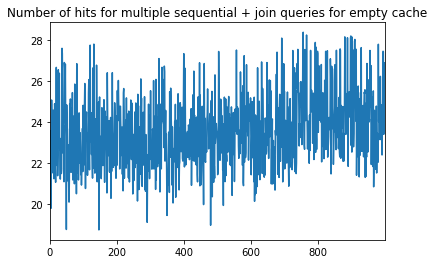

In [127]:
(df_metrics["Total Hits"]).plot()
plt.title("Number of hits for multiple sequential + join queries for empty cache")

In [128]:
max_time_steps

{'sequential': 66, 'select': 11, 'join': 111}

In [129]:
def evaluate_policy(query, q_table):
    cache_map_policy = []
    
    start_index = max_time_steps[query.query_type]
    
    reward = 0
    
    for d in q_table[start_index:]:
        action = ["mru", "lru"][np.argmax(d)]
        cache_map_policy.append({"action": action, 
                                 "cache": query.cache.cache_map.copy().keys(),
                                "which_element": query.parameters.copy()})
        query.step(action)
        
        if query.is_done():
            break
    
    hits, misses = query.step()
    reward = hits -  misses
    return hits, misses
    

In [25]:
q1, q2 = multisetup()

h1, miss1 = evaluate_policy(q1, q_table)
h2, miss2 = evaluate_policy(q2, q_table)

In [ ]:
h1, miss1, h2, miss2

In [ ]:
q1, q2 = multisetup()
get_baseline(q1), get_baseline(q2)

In [130]:
def get_baseline(query, action = "lru"):
    cache_map_baseline = []
    
    while not query.is_done():
        query.step(action)
        cache_map_baseline.append({"cache": query.cache.cache_map.copy().keys(), 
                                   "which_element": query.parameters.copy()})
        
    hits, misses = query.step()
    return hits, misses

In [131]:
def compare_reward(query_type):
    
    env = setup()
    params_baseline = env.parameters.copy()
    params_random = env.parameters.copy()
    params_policy = env.parameters.copy()
    
    t = Time(0)
    query_baseline = Query(query_type=query_type, parameters=params_baseline, time=t)
    c = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline.set_query_cache(c)
    
    query_baseline_random = Query(query_type=query_type, parameters=params_random, time=t)
    c2 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline_random.set_query_cache(c2)
    
    query_policy = Query(query_type=query_type, parameters=params_policy, time=t)
    c3 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_policy.set_query_cache(c3)
    
    hits_policy, misses_policy = evaluate_policy(query_policy, q_table)
    hits_baseline, misses_baseline = get_baseline(query_baseline)
    hits_random, misses_random = get_baseline(query_baseline_random, "random")
    
    return {"hits_random" : hits_random, "misses_random": misses_random, 
            "hits_baseline": hits_baseline, "misses_baseline": misses_baseline,
           "hits_policy": hits_policy, "misses_policy": misses_policy, "tm": query_baseline.time.now()}

In [132]:
def compare_query_reward(env):
    params_baseline = env.parameters.copy()
    params_random = env.parameters.copy()
    params_policy = env.parameters.copy()
    query_type = env.query_type
    
    t = Time(0)
    query_baseline = Query(query_type=query_type, parameters=params_baseline, time=t)
    c = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline.set_query_cache(c)
    
    query_baseline_random = Query(query_type=query_type, parameters=params_random, time=t)
    c2 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_baseline_random.set_query_cache(c2)
    
    query_policy = Query(query_type=query_type, parameters=params_policy, time=t)
    c3 = Cache(cache_size, time=t, equate_id_to_value=True)
    query_policy.set_query_cache(c3)
    
    hits_policy, misses_policy = evaluate_policy(query_policy, q_table)
    hits_baseline, misses_baseline = get_baseline(query_baseline)
    hits_random, misses_random = get_baseline(query_baseline_random, "random")
    
    return {"hits_random" : hits_random, "misses_random": misses_random, 
            "hits_baseline": hits_baseline, "misses_baseline": misses_baseline,
           "hits_policy": hits_policy, "misses_policy": misses_policy, "tm": query_baseline.time.now()}

In [ ]:
results_multi_query = []

for i in range(1000):
    q1, q2 = multisetup()
    r1 = compare_query_reward(q1)
    r2 = compare_query_reward(q2)
    
    total_r = {}
    for x, y in r1.items():
        total_r[x] = y
        
    for x, y in r2.items():
        total_r[x] += y
        
    results_multi_query.append(total_r)

In [ ]:
df_results = pd.DataFrame(results_multi_query)

In [ ]:
df_results

In [ ]:
results = []

for i in range(1000):
    res = compare_reward("join")
    results.append(res)

In [133]:
df_results = pd.DataFrame(results)

NameError: name 'results' is not defined

In [32]:
df_results["reward_policy"] = df_results["hits_policy"] - df_results["misses_policy"]
df_results["reward_random"] = df_results["hits_random"] - df_results["misses_random"]
df_results["reward_baseline"] = df_results["hits_baseline"] - df_results["misses_baseline"]

NameError: name 'df_results' is not defined

In [134]:
(df_results["reward_policy"] >= df_results["reward_baseline"]).value_counts()

NameError: name 'df_results' is not defined

In [135]:
df_q_value = pd.DataFrame(q_values_cumulative)


In [136]:
df_q_value.min(), df_q_value.max()

(q_values_cumulative    0.00217
 dtype: float64, q_values_cumulative    0.008591
 dtype: float64)

In [137]:
df = pd.DataFrame(cum_reward_plot)

In [138]:
df

,reward,epoch,time
0,-8,1,41
1,-10,2,42
2,-28,3,41
3,-32,4,45
4,-10,5,41
...,...,...,...
99994,-32,99995,47
99995,-6,99996,43
99996,-10,99997,40
99997,0,99998,34


In [139]:
df["r"] = df["reward"] / df["time"]

In [140]:
# df["reward"] = (df["reward"]-df["reward"].mean())/df["reward"].std()

In [141]:
df.reward.max()

16

In [142]:
df["rolling_mean"] = df["r"].rolling(200).mean()

In [143]:
df_q_value = pd.DataFrame(q_values_cumulative)
df_q_value.head()
df_q_value["rolling"] = df_q_value.rolling(1000).mean()

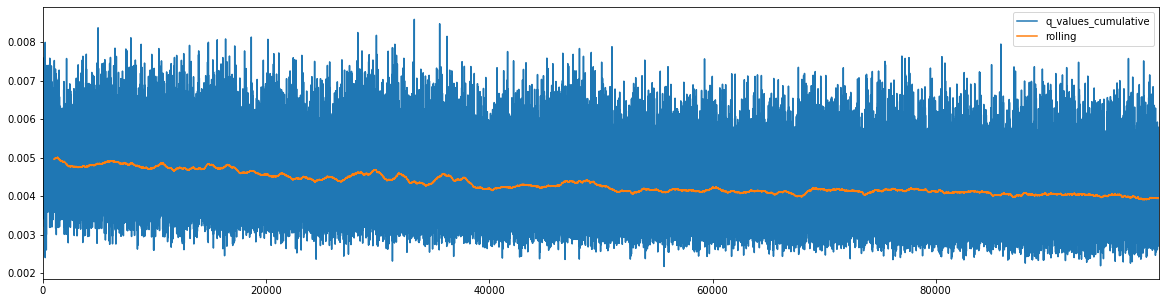

In [144]:
df_q_value.plot(figsize=(20,5))

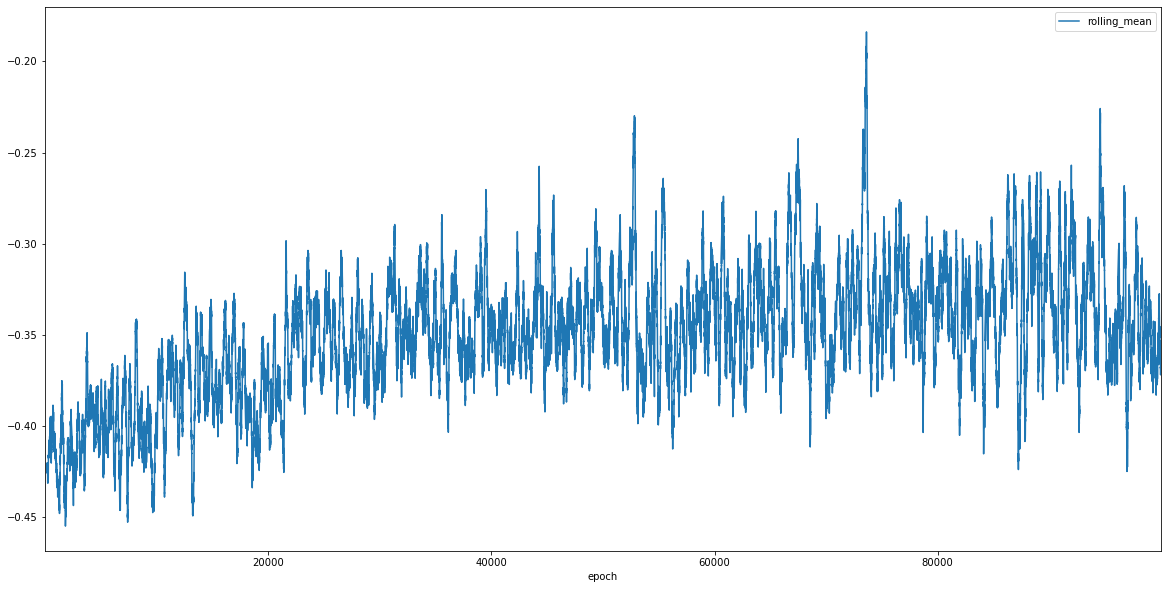

In [145]:
df.plot(y="rolling_mean", x="epoch", figsize=(20, 10))

In [ ]:
result = "Results/runs_{}_alpha_{}_gamma_{}_cache_{}.csv".format(number_of_runs, alpha, gamma, cache_size)

In [ ]:
df.to_csv(result)

In [50]:
max_time_steps

{'sequential': 66, 'select': 11, 'join': 111}

In [44]:
sequential = pd.DataFrame(q_table[66:111])
join = pd.DataFrame(q_table[111:])